In [2]:
import pandas as pd
import numpy as np

import pylab as P

In [3]:
df = pd.read_csv('./datasets/train.csv', header=0)

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


D:\Programs\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df[df['Age'].isnull()][['Sex', 'Pclass', 'Age']]

for i in range(1,4):
    print i, len(df[ (df['Sex'] != 'female') & (df['Pclass'] == i) ])

1 122
2 108
3 347


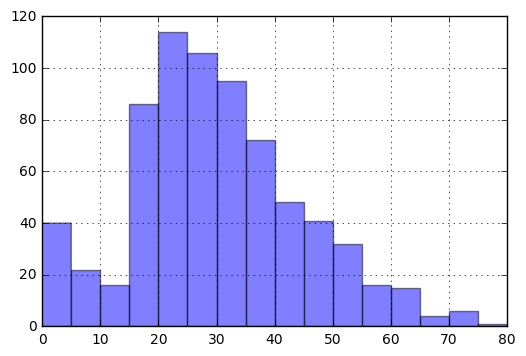

In [5]:
df['Age'].dropna().hist(bins=16, range=(0,80), alpha = .5)
P.show()

In [6]:
df['Gender'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0


In [7]:
df['Station'] = df['Embarked'].map( {'S': 1, 'C': 2, 'Q': 3} ).fillna(0).astype(int)
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Station
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1


In [8]:
median_ages = np.zeros((2,3))

for i in range(0,2):
    for j in range(0,3):
        median_ages[i,j] = df[ (df['Gender'] == i) & (df['Pclass'] == j+1) ]['Age'].dropna().median() 
        
median_ages

df['AgeFill'] = df['Age']
df.head()

for i in range(0,2):
    for j in range(0,3):
        df.loc[ (df['Age'].isnull()) & (df['Gender'] == i) & (df['Pclass'] == j+1), 'AgeFill' ] = median_ages[i,j]
        
df['AgeIsNull'] = pd.isnull(df['Age']).astype(int)
        
df[ df['Age'].isnull() ][['Gender', 'Pclass', 'Age', 'AgeFill', 'AgeIsNull']].head(10)

,Gender,Pclass,Age,AgeFill,AgeIsNull
5,1,3,NaN,25.0,1
17,1,2,NaN,30.0,1
19,0,3,NaN,21.5,1
26,1,3,NaN,25.0,1
28,0,3,NaN,21.5,1
29,1,3,NaN,25.0,1
31,0,1,NaN,35.0,1
32,0,3,NaN,21.5,1
36,1,3,NaN,25.0,1
42,1,3,NaN,25.0,1


In [9]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Gender,Station,AgeFill,AgeIsNull
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.647587,1.359147,29.112424,0.198653
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.477989,0.638710,13.304424,0.399212
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.420000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400,0.000000,1.000000,21.500000,0.000000
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200,1.000000,1.000000,26.000000,0.000000
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000,1.000000,2.000000,36.000000,0.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,3.000000,80.000000,1.000000


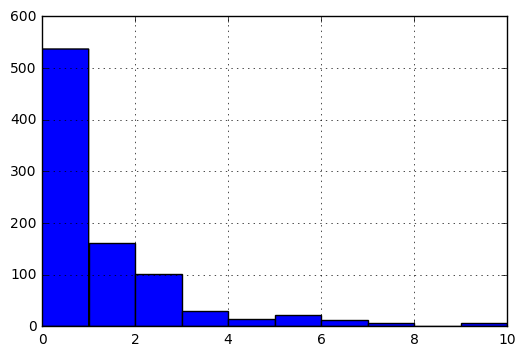

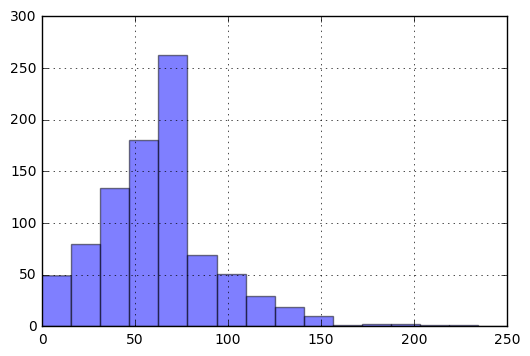

In [10]:
df['FamilySize'] = df['SibSp'] + df['Parch']

df['Age*Class'] = df['AgeFill'] * df['Pclass']

df['FamilySize'].hist()
P.show()
df['Age*Class'].hist(bins=16, range=(0,250), alpha = .5)
P.show()

In [12]:
df.dtypes[df.dtypes.map( lambda x: x == 'object' )]

df = df.drop(df[['Name', 'Sex', 'Age', 'Ticket', 'Cabin', 'Embarked']], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Gender         891 non-null int32
Station        891 non-null int32
AgeFill        891 non-null float64
AgeIsNull      891 non-null int32
FamilySize     891 non-null int64
Age*Class      891 non-null float64
dtypes: float64(3), int32(3), int64(6)
memory usage: 73.2 KB


In [13]:
train_data = df.values
train_data

array([[   1. ,    0. ,    3. , ...,    0. ,    1. ,   66. ],
       [   2. ,    1. ,    1. , ...,    0. ,    1. ,   38. ],
       [   3. ,    1. ,    3. , ...,    0. ,    0. ,   78. ],
       ..., 
       [ 889. ,    0. ,    3. , ...,    1. ,    3. ,   64.5],
       [ 890. ,    1. ,    1. , ...,    0. ,    0. ,   26. ],
       [ 891. ,    0. ,    3. , ...,    0. ,    0. ,   96. ]])